```
This software is part of GPU Ocean. 

Copyright (C) 2024 SINTEF Digital

Tutorial for implementing new drift functionality.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```


# A field of drifters in a single ocean model

The goal of this tutorial  is to give a compact example of how to run a field of drifters in a single ocean model

In [1]:
# Load required modules
%matplotlib inline

from IPython.display import display

import numpy as np
import copy 

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

# Import relevant modules from within GPU Ocean
from gpuocean.SWEsimulators import GPUOceanSim
from gpuocean.utils import IPythonMagic, NetCDFInitialization, PlotHelper, DrifterPlotHelper
from gpuocean.drifters import GPUDrifterCollection, LagrangianUtils

from importlib import reload

In [2]:
# Create the GPU context
%cuda_context_handler gpu_ctx

#### Domain and ocean simulator

In [3]:
# Url or path to operational ocean forecast
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

# Use a predefined subdomain
casename = 'north_cape'

reload(NetCDFInitialization)
T_end_hours = 23

# Load initial and boundary conditions, bathymetry, landmask, forcing, etc
sim_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url, casename, timestep_indices=list(range(T_end_hours+1)))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


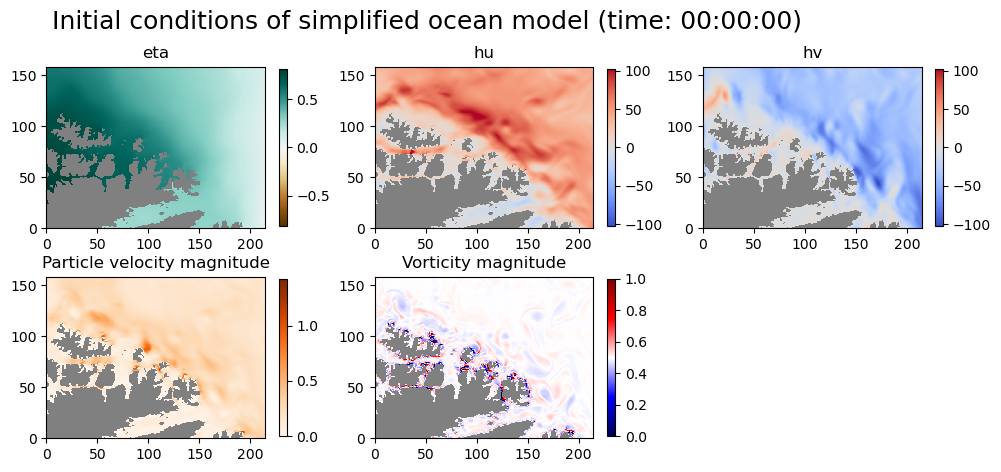

In [4]:
if 'sim' in globals():
    sim.cleanUp()

# Refine the grid twice, so that we run with 400x400 m resolution instead of NorKyst's 800x800 m
fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 2)

# Create simulation object
sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(fine_sim_args))


# Plot initial conditions of the simplified ocean model
_, _ = PlotHelper.plotSim(sim, plot_title="Initial conditions of simplified ocean model", add_extra=True)

#### Initialize drifter and attach to ocean simulator

In [5]:
# Initial positions for drifters chosen as a uniformly distributed rectangle outside of North Cape

x_positions = np.arange(100, 151, 0.05)*1000
y_positions = np.arange(100, 121, 0.05)*1000

num_drifters = len(x_positions)*len(y_positions)
print("Running with "+str(num_drifters)+" drifters")
init_positions = np.zeros((num_drifters, 2))
d = 0
for x in x_positions:
    for y in y_positions:
        init_positions[d, 0] = x
        init_positions[d, 1] = y
        d = d+1        

Running with 428400 drifters


In [6]:
# Create drifter object
drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                     boundaryConditions=sim.boundary_conditions,
                                                     domain_size_x=sim.nx*sim.dx,
                                                     domain_size_y=sim.ny*sim.dy)
drifters.setDrifterPositions(init_positions)

# Attach the drifters to the simulator
sim.attachDrifters(drifters)

Text(0.5, 1.0, 'Initial positions')

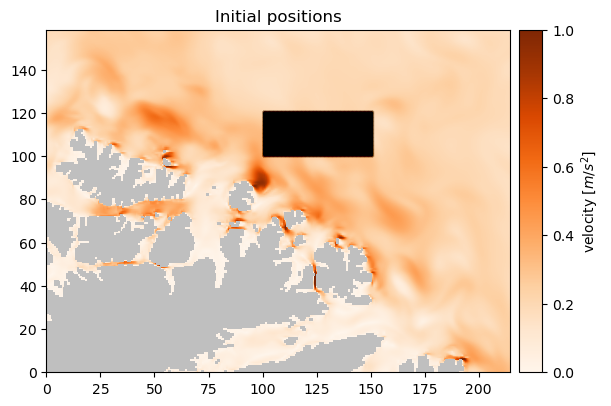

In [7]:
# Plot initial positions of Lagrangian particles
ax = DrifterPlotHelper.background_from_sim(sim, vmax=1.0)
DrifterPlotHelper.add_drifter_positions_on_background(ax, drifters.getDrifterPositions(), s=0.05, alpha=0.01)
ax.set_title("Initial positions")

#### Run simulation and plot intermediate and final concentration of Lagrangian particles

In [8]:
def plotConcentration(sim):
    c = LagrangianUtils.concentrationFromSim(sim, total_concentration=sim.drifters.getNumDrifters())

    fig = plt.figure()
    cmap = copy.copy(plt.cm.gist_stern_r)
    cmap.set_bad(color='grey')
    plt.imshow(c, origin='lower', cmap=cmap, vmax=75)
    plt.colorbar()


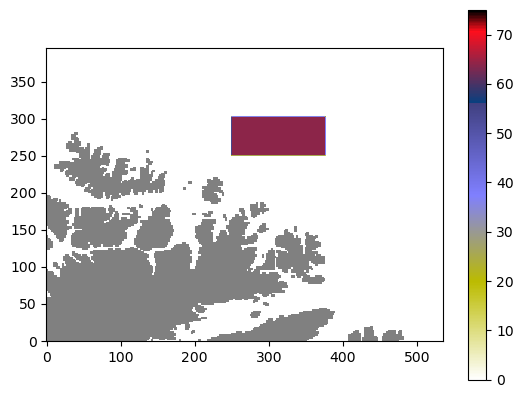

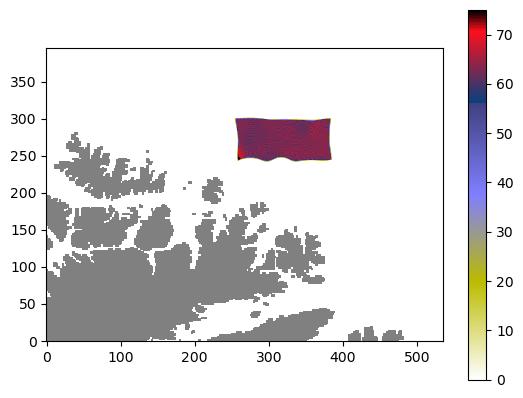

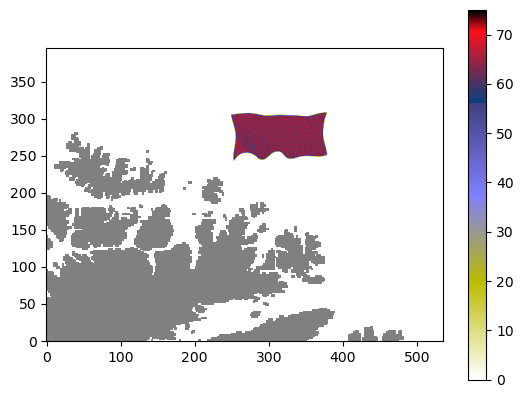

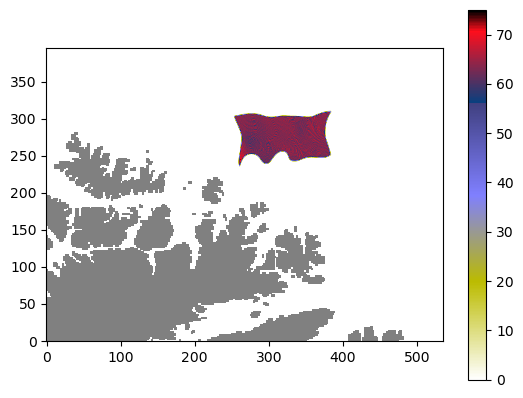

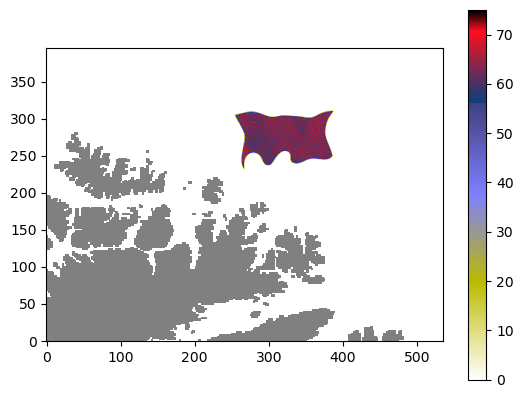

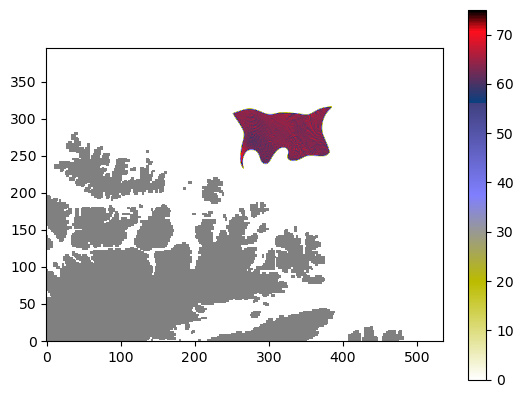

In [9]:
for i in range(T_end_hours+1):
    if i > 0:
        sim.step(3600)

    if i in [0, 4, 9, 14, 19, T_end_hours]:
        plotConcentration(sim)